In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [24]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [25]:
dataset_train.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [26]:
training_set = dataset_train.iloc[:, 1: 2].values

In [27]:
training_set.shape

(1258, 1)

In [28]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [29]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
 X_train.append(training_set_scaled[i-60: i, 0])
 y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
X_train.shape

(1198, 60)

In [31]:
y_train.shape

(1198,)

In [32]:
#data reshaping
X_train = np.reshape(X_train, newshape =
 (X_train.shape[0], X_train.shape[1], 1))

In [33]:
X_train.shape

(1198, 60, 1)

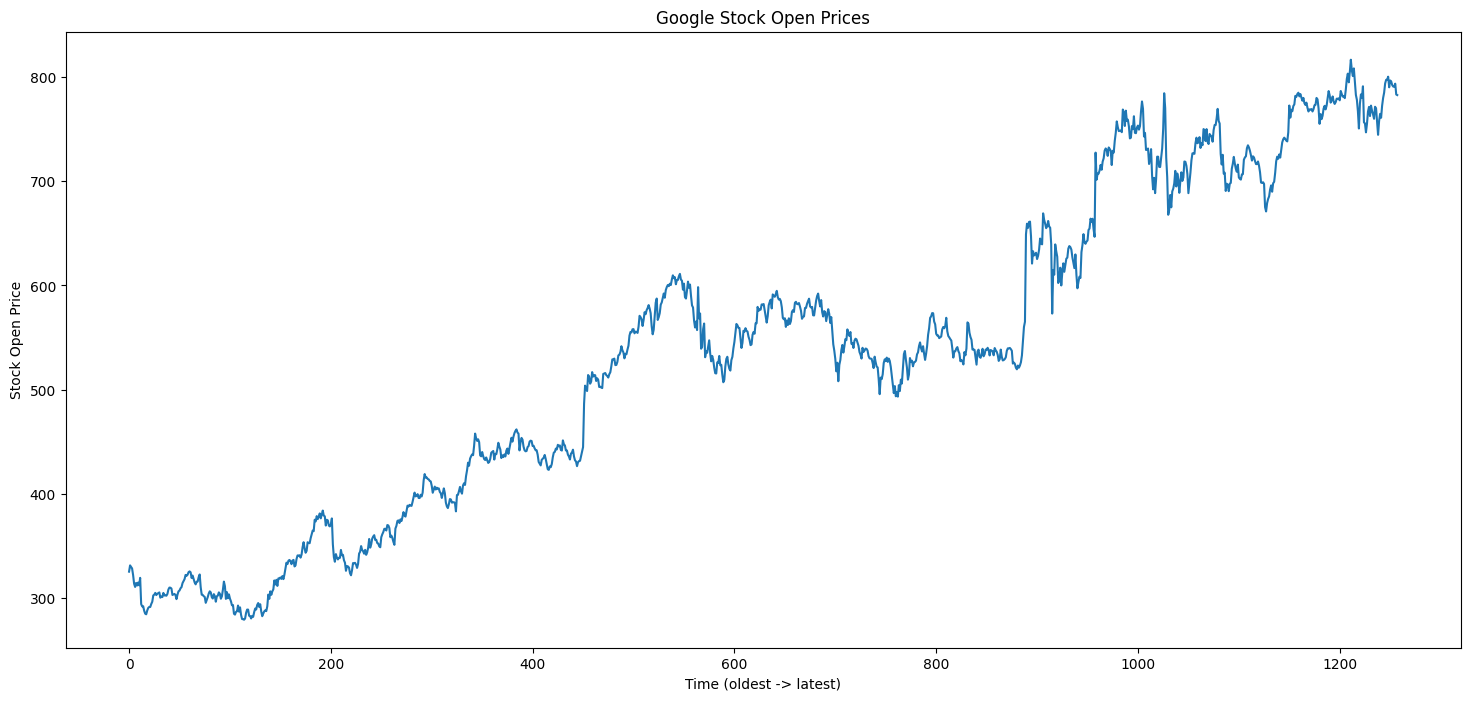

In [34]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

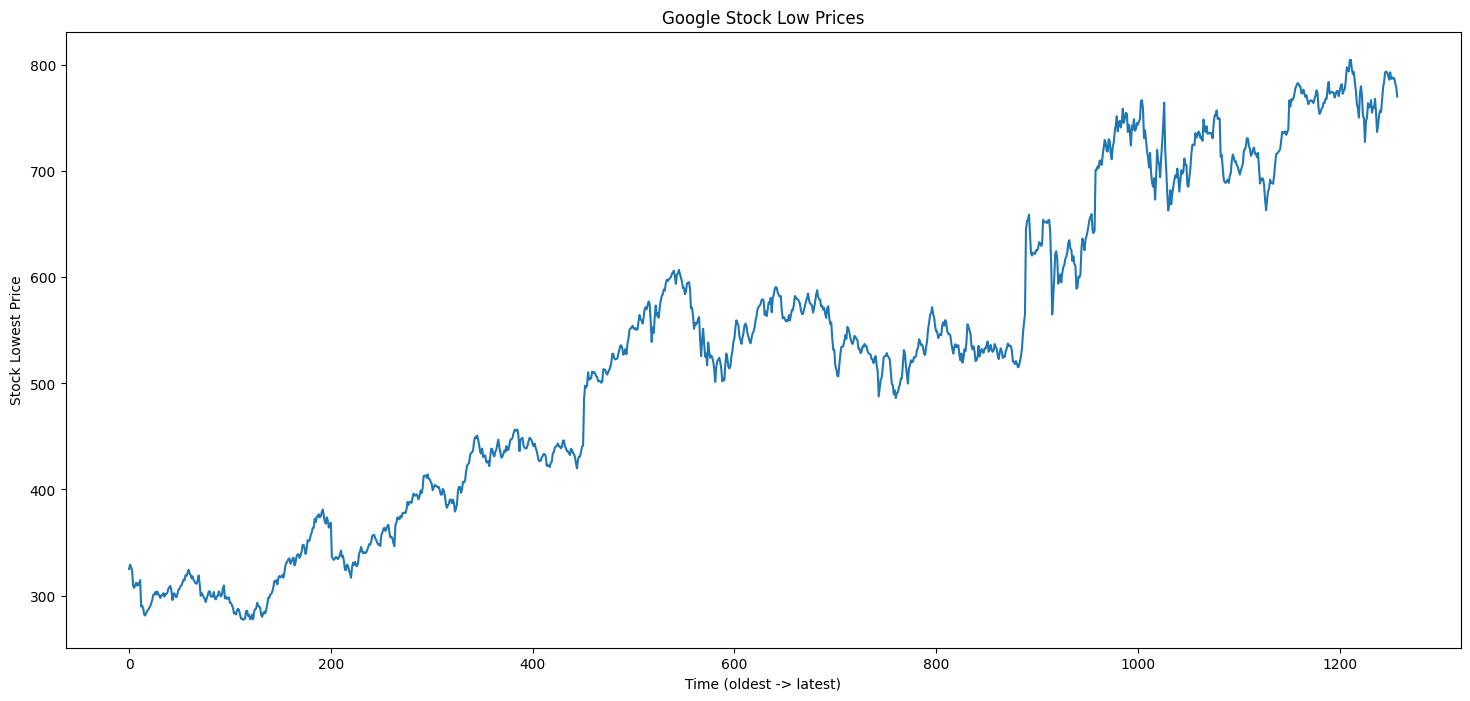

In [35]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Low'])
plt.title("Google Stock Low Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Price")
plt.show()

In [36]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))
##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))
##add output layer
regressor.add(Dense(units = 1))

In [37]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
38/38 [==============================] - 12s 84ms/step - loss: 0.0373
Epoch 2/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0065
Epoch 3/100
38/38 [==============================] - 3s 80ms/step - loss: 0.0070
Epoch 4/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0059
Epoch 5/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0048
Epoch 6/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0050
Epoch 7/100
38/38 [==============================] - 4s 108ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 8s 220ms/step - loss: 0.0048
Epoch 9/100
38/38 [==============================] - 8s 222ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 9s 233ms/step - loss: 0.0040
Epoch 11/100
38/38 [==============================] - 9s 228ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 8s 210ms/step - loss: 0.0041
Epoch 13/100
38/38

In [48]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [49]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [50]:

#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape


(20, 1)

In [40]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']),
 axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [41]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)
#scale input
inputs = sc.transform(inputs)

In [42]:
len(inputs)

80

In [43]:
X_test = []
for i in range(60, len(inputs)):
 X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [44]:
X_test.shape

(20, 60, 1)

In [45]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [46]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

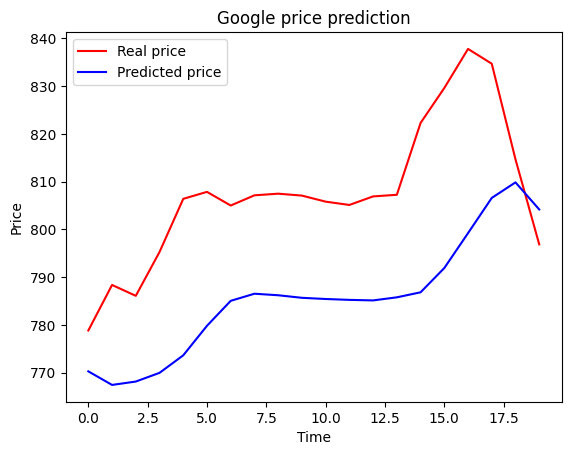

In [47]:
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()